In [42]:
using Revise
using RadiativeTransfer
using RadiativeTransfer.PhaseFunction
using RadiativeTransfer.RTM
using Distributions

"Generate aerosol optical properties"
FT = Float64

# Wavelength (just one for now)
λ = 0.770       # Incident wavelength
depol = 0.029
# Truncation 
Ltrunc = 72             # Truncation  
truncation_type   = PhaseFunction.δBGE(Ltrunc, 2.0)

# polarization_type
polarization_type = Stokes_I{FT}()

# Quadrature points for RTM
# Nquad, qp_μ, wt_μ = rt_set_streams(RTM.RadauQuad(), Ltrunc, 60.0, [0.0, 15.0, 30., 45., 60.])
vza = [60., 45., 30., 15., 0., 15., 30., 45., 60.]
vaz = [180., 180., 180., 180., 0., 0., 0., 0., 0.]
sza = 30.
Nquad, qp_μ, wt_μ = rt_set_streams(RTM.RadauQuad(), Ltrunc, sza, vza);

# Aerosol particle distribution and properties
μ            = [0.3] #[0.3,2.0]       # Log mean radius
σ            = [2.0] #[2.0,1.8]       # Log stddev of radius
r_max        = [30.0] #[30.0,30.0]     # Maximum radius
nquad_radius = [2500] #[2500,2500]     # Number of quadrature points for integrating of size dist.
nᵣ           = [1.3] #[1.3, 1.66]     # Real part of refractive index
nᵢ           = [0.001] #[0.001,0.0003]  # Imag part of refractive index

#Aerosol vertical distribution profiles
p₀          = [50000.] #[50000., 20000.] # Pressure peak [Pa]
σp          = [5000.]   #[5000., 2000.]   # Pressure peak width [Pa]

size_distribution = [LogNormal(log(μ[1]), log(σ[1]))] #[LogNormal(log(μ[1]), log(σ[1])), LogNormal(log(μ[2]), log(σ[2]))]

# Create the aerosols (needs to be generalized through loops):
aero1 = make_univariate_aerosol(size_distribution[1], r_max[1], nquad_radius[1], nᵣ[1], nᵢ[1])
#aero2 = make_univariate_aerosol(size_distribution[2], r_max[2], nquad_radius[2], nᵣ[2], nᵢ[2])

# Define some details, run aerosol optics
model_NAI2_aero1 = make_mie_model(NAI2(), aero1, λ, polarization_type, truncation_type)
aerosol_optics_NAI2_aero1 = compute_aerosol_optical_properties(model_NAI2_aero1);
# Truncate:
aerosol_optics_trunc_aero1 = PhaseFunction.truncate_phase(truncation_type, aerosol_optics_NAI2_aero1)

# Define some details, run aerosol optics
#model_NAI2_aero2 = make_mie_model(NAI2(), aero2, λ, polarization_type, truncation_type)
#aerosol_optics_NAI2_aero2 = compute_aerosol_optical_properties(model_NAI2_aero2);
# Truncate:
#aerosol_optics_trunc_aero2 = PhaseFunction.truncate_phase(truncation_type, aerosol_optics_NAI2_aero2)

# Rayleigh Greek
GreekRayleigh = PhaseFunction.get_greek_rayleigh(depol)


(μ₀, Nquad, qp_μ, wt_μ) = (0.8660254037844386, 77, [0.0009143960245997507, 0.004810661753876733, 0.011790871964997507, 0.021806297633265026, 0.03478496953367899, 0.05063342212789057, 0.06923748239334376, 0.09046311399894857, 0.11415738878412757, 0.14014959052598386, 0.16825244570148545, 0.19826347312543285, 0.22996644298936766, 0.2631329348833307, 0.2975239836142949, 0.3328918009809475, 0.36898156110799757, 0.40553323648098644, 0.4422834714551921, 0.47896747974109993, 0.5153209521954968, 0.5510819611725047, 0.585992847713176, 0.619802077975278, 0.6522660555254728, 0.6831508764321805, 0.7122340145057356, 0.7393059245276952, 0.7641715518839248, 0.7866517376462151, 0.8065845087819288, 0.8238262436414934, 0.8382527025182286, 0.8497599086345979, 0.8582648342889148, 0.8637055353340137, 0.8660254037844386, 0.866166861341736, 0.8667696157477238, 0.8678494580253845, 0.8693988497683629, 0.8714066572988046, 0.8738584214476072, 0.8767364795867129, 0.8800200962235396, 0.8836856132893127, 0.88770662

GreekCoefs{Float64}([0.0, 0.0, 2.8713652045342535], [1.0, 0.0, 0.4785608674223756], [0.0, 0.0, 1.1722299360485293], [0.0, 1.392804337111878, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0])

In [43]:
" Atmospheric Profiles, basics, needs to be refactore entirely"
file = "/Users/sanghavi/GDrive/code/github/atm_profiles/MERRA300.prod.assim.inst6_3d_ana_Nv.20150613.hdf.nc4"   
timeIndex = 2 # There is 00, 06, 12 and 18 in UTC, i.e. 6 hourly data stacked together

# What latitude do we want? 
myLat = 34.1377;
myLon = -118.1253;

# Read profile (and generate dry/wet VCDs per layer)
profile_caltech = RTM.read_atmos_profile(file, myLat, myLon, timeIndex);

# Compute layer optical thickness for Rayleigh (surface pressure in hPa) 
τRayl =  RTM.getRayleighLayerOptProp(profile_caltech.psurf/100, λ, depol, profile_caltech.vcd_dry);
ϖRayl = ones(length(τRayl))

#Compute Naer aerosol optical thickness profiles
τAer_1 = RTM.getAerosolLayerOptProp(1.0, p₀[1], σp[1], profile_caltech.p_levels)
#τAer_2 = RTM.getAerosolLayerOptProp(0.3, p₀[2], σp[2], profile_caltech.p_levels)

# Can be done with arbitrary length later:
τAer = 0*τAer_1 #[τAer_1 τAer_2]
@show sum(τAer_1)#, sum(τAer_2)
ϖAer = [aerosol_optics_NAI2_aero1.ω̃] #[aerosol_optics_NAI2_aero1.ω̃ aerosol_optics_NAI2_aero2.ω̃];
fᵗ   = [aerosol_optics_trunc_aero1.fᵗ] #[aerosol_optics_trunc_aero1.fᵗ aerosol_optics_trunc_aero2.fᵗ];


(psurf, tau_scat, depol_fct) = (968.854375, 0.024922777884628752, 0.029)
sum(τAer_1) = 0.9999999999999998


In [44]:
(τAer[10,:])
profile_caltech.p_levels[73]

96885.4375

In [45]:
@show polarization_type
m = 0
RaylZ⁺⁺, RaylZ⁻⁺     = PhaseFunction.compute_Z_moments(polarization_type, qp_μ, GreekRayleigh, m);
aero1_Z⁺⁺, aero1_Z⁻⁺ = PhaseFunction.compute_Z_moments(polarization_type, qp_μ, aerosol_optics_trunc_aero1.greek_coefs, m);
#aero2_Z⁺⁺, aero2_Z⁻⁺ = PhaseFunction.compute_Z_moments(polarization_type, qp_μ, aerosol_optics_trunc_aero2.greek_coefs, m);
aerosol_optics = [aerosol_optics_trunc_aero1] #[aerosol_optics_trunc_aero1 aerosol_optics_trunc_aero2]
Aer𝐙⁺⁺ = [aero1_Z⁺⁺] #[aero1_Z⁺⁺, aero2_Z⁺⁺];
Aer𝐙⁻⁺ = [aero1_Z⁻⁺] #[aero1_Z⁻⁺, aero2_Z⁻⁺];
@show size(τAer[1])
iz = 10
τ, ϖ, Z⁺⁺, Z⁻⁺  = RTM.construct_atm_layer(τRayl[iz], τAer[iz,:], ϖRayl[iz], ϖAer, fᵗ, RaylZ⁺⁺, RaylZ⁻⁺, Aer𝐙⁺⁺, Aer𝐙⁻⁺)
@show τ, ϖ
@show τAer[iz], τRayl[iz]
dims = size(RaylZ⁺⁺)
@show dims

polarization_type = Stokes_I{Float64}
  n: Int64 1
  D: Array{Float64}((1,)) [1.0]
  I0: Array{Float64}((1,)) [1.0]

size(τAer[1]) = ()
(τ, ϖ) = (2.2332106947863025e-6, 1.0)
(τAer[iz], τRayl[iz]) = (0.0, 2.2332106947863025e-6)
dims = (77, 77)


(77, 77)

In [46]:
@time R,T = RTM.run_RTM(polarization_type, sza, vza, vaz, τRayl,ϖRayl, τAer, ϖAer, fᵗ, qp_μ, wt_μ, 3, aerosol_optics, GreekRayleigh)

μ0 = 0.8660254037844386
iμ0 = 37
dims = (77,)
m = 0
size(Rayl𝐙⁺⁺) = (77, 77)
weight * bigCS * R⁻⁺[istart:iend, istart0:iend0] = [7.72296211590854e-6]
wt_μ[iμ0] = 0.0006325970809236221
weight * bigCS * R⁻⁺[istart:iend, istart0:iend0] = [6.090653255239481e-6]
wt_μ[iμ0] = 0.0006325970809236221
weight * bigCS * R⁻⁺[istart:iend, istart0:iend0] = [5.471604283861906e-6]
wt_μ[iμ0] = 0.0006325970809236221
weight * bigCS * R⁻⁺[istart:iend, istart0:iend0] = [5.230062535670684e-6]
wt_μ[iμ0] = 0.0006325970809236221
weight * bigCS * R⁻⁺[istart:iend, istart0:iend0] = [5.16620541684431e-6]
wt_μ[iμ0] = 0.0006325970809236221
weight * bigCS * R⁻⁺[istart:iend, istart0:iend0] = [5.230062535670684e-6]
wt_μ[iμ0] = 0.0006325970809236221
weight * bigCS * R⁻⁺[istart:iend, istart0:iend0] = [5.471604283861906e-6]
wt_μ[iμ0] = 0.0006325970809236221
weight * bigCS * R⁻⁺[istart:iend, istart0:iend0] = [6.090653255239481e-6]
wt_μ[iμ0] = 0.0006325970809236221
weight * bigCS * R⁻⁺[istart:iend, istart0:iend0] = [7.7229621

([0.01625049304451154; 0.012670925859519386; … ; 0.007357198992185996; 0.009791689652043257], [0.00978614366979131; 0.007351942650785164; … ; 0.012669625245731888; 0.01625190833704417])

In [52]:
using Plots
using DelimitedFiles
S1=readdlm("/Users/sanghavi/GDrive/code/github/RadiativeTransfer.jl/src/Notebooks/Rayl_orig_new.dat", ' ')
vza=[-60. -45. -30. -15. 0. 15. 30. 45. 60.]
I_rayl0=S1[:,1]
Q_rayl0=S1[:,2]
U_rayl0=S1[:,3]
V_rayl0=S1[:,4]

S2=readdlm("/Users/sanghavi/GDrive/code/github/RadiativeTransfer.jl/src/Notebooks/Rayl_orig.dat", ' ')
I_rayl00=S2[:,1]
Q_rayl00=S2[:,2]
U_rayl00=S2[:,3]
V_rayl00=S2[:,4]


if polarization_type == Stokes_I
    plot(vza', [R[:,1], I_rayl0, I_rayl00], title="I, 775 nm", label=["julia" "bolshoi" "bolshoi0"], lw=2,       legend=:topright, size = (600, 400))
else
    p1=plot(vza', [R[:,1], I_rayl0, I_rayl00], title="I, 775 nm", label=["julia" "bolshoi" "bolshoi0"], lw=2,    legend=:topright, size = (600, 400))
    p2=plot(vza', [R[:,2], Q_rayl0, Q_rayl00], title="Q, 775 nm", label=["julia" "bolshoi" "bolshoi0"], lw=2,
    legend=:topleft, size = (600, 400))
    plot(p1, p2, layout=(2, 1))
end

LoadError: BoundsError: attempt to access 9×1 Array{Float64,2} at index [1:9, 2]

In [61]:
i = RTM.nearest_point(qp_μ, 0.5)

11

In [89]:
using LinearAlgebra
phi = 180
m=0
cos_m_phi = cosd(m*phi)
sin_m_phi = sind(m*phi)

Diagonal([cos_m_phi, cos_m_phi, sin_m_phi, sin_m_phi])

4×4 Diagonal{Float64,Array{Float64,1}}:
 1.0   ⋅    ⋅    ⋅ 
  ⋅   1.0   ⋅    ⋅ 
  ⋅    ⋅   0.0   ⋅ 
  ⋅    ⋅    ⋅   0.0

In [41]:
plot(profile_caltech.p_levels)
profile_caltech.p_levels[end]

96885.4375

In [38]:
S1=readdlm("/Users/sanghavi/GDrive/code/github/RadiativeTransfer.jl/src/Notebooks/mon06lat35n.mpi", skipstart=3)

34×12 Array{Float64,2}:
 34.0  60.6    0.14  229.02  0.849    …  0.0      2.176e-5   5.355e-6
 33.0  58.6    0.22  241.76  0.902       0.0      2.955e-5   2.595e-5
 32.0  56.5    0.3   248.21  1.166       0.0      4.013e-5   7.791e-5
 31.0  54.4    0.39  254.44  1.393       0.0      5.256e-5   7.249e-5
 30.0  52.2    0.53  260.53  1.647       0.0      6.79e-5    7.517e-5
 29.0  50.0    0.71  265.61  1.945    …  0.0      8.493e-5   7.814e-5
 28.0  47.7    0.96  269.37  2.312       0.0      0.0001035  7.944e-5
 27.0  45.5    1.28  270.88  2.762       0.0      0.0001222  7.601e-5
 26.0  43.3    1.7   269.74  3.322       0.0      0.0001382  6.858e-5
 25.0  41.1    2.27  265.77  4.015       0.0      0.000148   5.898e-5
 24.0  39.0    3.03  260.26  4.871    …  1.0e-7   0.0001492  4.948e-5
 23.0  36.9    4.03  254.46  5.873       1.6e-7   0.0001441  4.103e-5
 22.0  34.8    5.44  248.39  6.892       3.0e-7   0.0001355  3.693e-5
  ⋮                                   ⋱           ⋮          
 12.

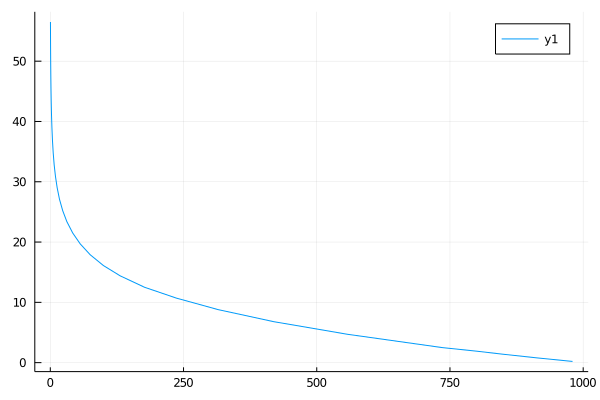

In [39]:
z=S1[3:end,2]
p=S1[3:end,3]
plot(p,z)

In [42]:
@show τRayl
@show sum(τRayl)

τRayl = [2.458321228068743e-7, 3.122067063797429e-7, 3.659210487514052e-7, 4.5269967561020355e-7, 5.738948540520104e-7, 7.462966596403624e-7, 9.782146946243767e-7, 1.2747366441703955e-6, 1.6514254364346214e-6, 2.126814916654541e-6, 2.7229564361440845e-6, 3.4655656473803567e-6, 4.384534594659293e-6, 5.514158741370244e-6, 6.909597012386021e-6, 8.610999362046342e-6, 1.0673533492988665e-5, 1.3157912479068814e-5, 1.6131986637910835e-5, 1.9670008489807117e-5, 2.3851358997120272e-5, 2.8762343419384757e-5, 3.4491232793154476e-5, 4.113015584595999e-5, 4.877209434559629e-5, 5.817616629638912e-5, 6.916980487696156e-5, 8.197273528402019e-5, 9.682838891988656e-5, 0.00011400219310149508, 0.00013378682554071624, 0.0001564820747675095, 0.00018359978495951913, 0.00021495564648260588, 0.0002511299716844261, 0.00029275915394862194, 0.00034056133773075235, 0.00040063986134184615, 0.0004713589950432979, 0.0005544989515574015, 0.0006523635556957106, 0.0007622049825989785, 0.0008866461370709368, 0.0010348388

0.023735394019581548

In [43]:
profile_caltech.psurf/100


968.854375

In [ ]:
function compute_Raman_shifts(lambda, v_init, wn_vib, J_init)
       #Only for homonuclear diatoms like N2 and O2
       
       #Initial state
       E_init_v = h_Planck * c_light * wn_vib * (v_init+0.5)

       #Vibrational shifts
       if v_init>0:
           E_Obranch = h_Planck * c_light * wn_vib * (v_init-0.5) #v = v_init - 1
       E_Sbranch = h_Planck * c_light * wn_vib * (v_init+1.5)     #v = v_init + 1

       #Rotational shifts
       for dv = -1:1; dJ={-2,0.2};
            v = v_init + dv
            J = J_init + dJ
            JJp1 = J*(J+1) 
            E_rot_J_v[0, 0] =  h_Planck * c_light * (B_v*JJp1 - D_v*JJp1^2)
